In [43]:
import cv2
import numpy
import pandas
import tensorflow
import pytesseract
import os
from PIL import Image
from pytesseract import Output
from matplotlib import pyplot as plt


In [58]:
img_location = "./data/images_data/1001(2023-06-07T08_06_44).jpg"

In [59]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Change to os.path in the future
img = cv2.imread(img_location)

In [61]:
box_id = img_location.split("/")[-1].split("(")[0]
print(img_location)
print(box_id)

./data/images_data/1001(2023-06-07T08_06_44).jpg
1001


In [62]:
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

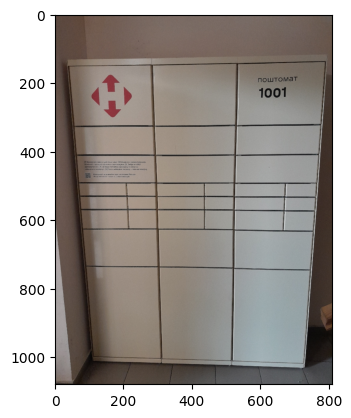

In [63]:
plt.imshow(rgb)
plt.show()

In [66]:
t = pytesseract.image_to_string(img, config="outputbase digits")

In [68]:
print(t)

In [44]:
results = pytesseract.image_to_data(rgb, output_type=Output.DICT)

In [70]:
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]
	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(results["conf"][i])

In [41]:
data = pytesseract.image_to_data(img, output_type='dict')
boxes = len(data['level'])

for i in range(boxes):
    if data['text'][i] == box_id:
        print(data['left'][i], data['top'][i], data['width'][i], data['height'][i], data['text'][i])

In [73]:
def detect_number_location(image_path):
    image = cv2.imread(img_location)
    text = pytesseract.image_to_string(image, config='--psm 8')
    boxes = pytesseract.image_to_boxes(image, config='--psm 8')
    for box in boxes.splitlines():
        b = box.split()
        x, y, w, h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
        print(x,y,w,h)

    return text

detected_text = detect_number_location(img_location)
print("Detected Text:", detected_text)


0 0 810 1080
Detected Text: 4

